In [152]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm import trange
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score, completeness_score

# Graph creation
After collecting and pre-processing the data, the graphs are created to build a network between the stocks, using their sectors and correlation.

## Grouping by sector
The first step is to create a graph of the stocks linking every stock that belong to the same activity sector.

In [153]:
stocks = pd.read_csv('../data/SP100/raw/stocks.csv').set_index('Symbol')
stocks.head(n=10)

,Name,Sector
Symbol,,
AAPL,Apple,Information Technology
ABBV,AbbVie,Health Care
ABT,Abbott Laboratories,Health Care
ACN,Accenture,Information Technology
ADBE,Adobe,Information Technology
AIG,American International Group,Financials
AMD,AMD,Information Technology
AMGN,Amgen,Health Care
AMT,American Tower,Real Estate


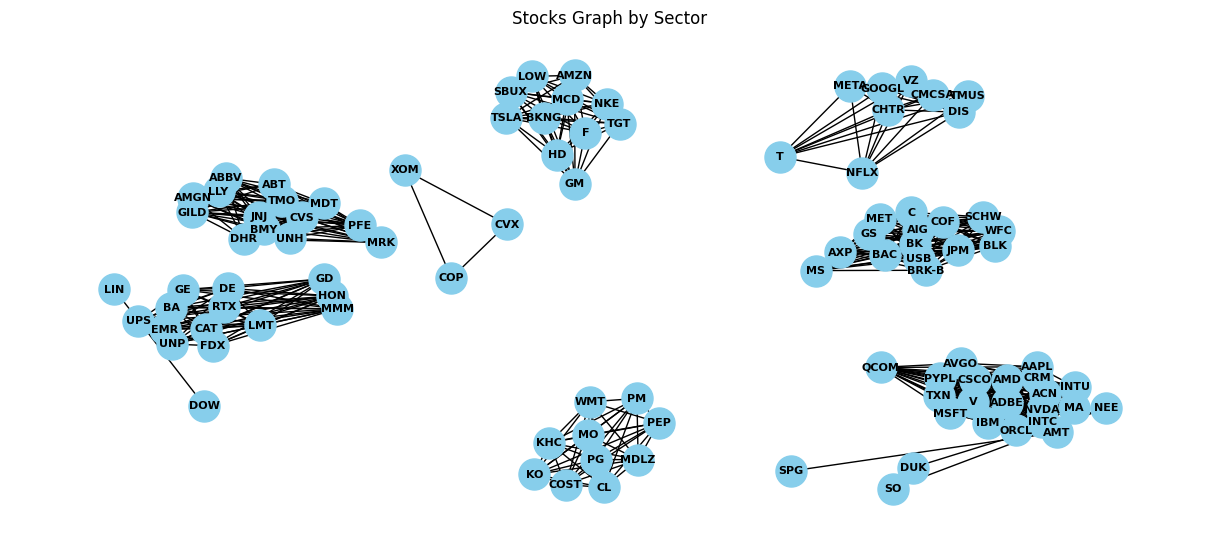

In [154]:
adj_stocks = np.array([
	[stocks.loc[stock1, 'Sector'] == stocks.loc[stock2, 'Sector'] * (stock1 != stock2) for stock1 in stocks.index] for stock2 in stocks.index
]).astype(int)
stocks_graph = nx.from_numpy_array(adj_stocks)
stocks_graph = nx.relabel_nodes(stocks_graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(stocks_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(stocks_graph, k=.5))
plt.title('Stocks Graph by Sector')
plt.show()

## Graph by fundamentals correlation
A great way to link the stocks would be using their fundamental data, such as market capitalization, p/e ratio, etc. An autoencoder is built to reduce the dimensionality of the fundamental data, and the stocks are clustered and linked following these clusters. Furthermore, the correlation between the fundamental data is used to link the stocks that have a high correlation.

In [155]:
fundamentals = pd.read_csv('../data/SP100/raw/fundamentals.csv').set_index("Symbol")
fundamentals.head(n=10)

,marketCap,trailingPE,forwardPE,pegRatio,priceToBook,trailingEps,forwardEps,bookValue,payoutRatio,beta,fiveYearAvgDividendYield,52WeekChange,averageVolume,enterpriseToRevenue,profitMargins
Symbol,,,,,,,,,,,,,,,
AAPL,4.755518,-0.063815,1.003310,0.264583,0.504617,-0.201799,-0.298911,-0.100854,-0.469191,0.755701,-0.958954,-0.586971,3.023333,0.532607,0.727630
ABBV,-0.050192,0.575305,-0.577851,0.144018,0.290156,-0.405209,-0.073455,-0.100827,1.188638,-1.091712,1.212553,-0.304221,-0.371315,0.283733,-0.403066
ABT,-0.251776,0.078547,0.210599,0.278936,-0.207015,-0.415115,-0.390661,-0.100405,0.036968,-0.635048,-0.444183,-0.714828,-0.376508,0.004878,-0.185283
ACN,-0.238962,-0.092671,0.498274,0.408113,-0.157783,0.100675,-0.022739,-0.099870,-0.177188,0.509206,-0.598022,-0.172348,-0.555901,-0.354519,-0.412458
ADBE,-0.187784,0.505232,0.579510,0.037806,-0.003196,0.063031,0.311526,-0.100101,-0.620723,0.745322,-1.319886,0.588215,-0.487604,1.183401,0.563165
AIG,-0.503579,-0.591716,-0.912753,-0.163136,-0.282827,-0.185288,-0.263871,-0.099317,-0.402305,0.112220,0.188927,0.793915,-0.465768,-0.675899,-0.479383
AMD,-0.138987,5.919639,1.193413,0.029194,-0.215835,-0.581542,-0.373602,-0.100086,-0.620723,1.687191,-1.390889,1.051030,3.206704,1.135390,-0.855715
AMGN,-0.284627,0.440462,-0.322013,0.370795,0.404059,-0.164815,0.341955,-0.100737,0.632036,-1.011277,0.366434,-0.013488,-0.542410,0.536918,-0.275429
AMT,-0.441109,0.334771,0.837427,-0.054053,0.141019,-0.335204,-0.307210,-0.100755,0.502122,-0.806297,-0.059583,-0.791576,-0.564777,1.462844,0.144312


In [156]:
def get_clusters(data: np.ndarray, n_clusters: int) -> np.ndarray:
    kmeans = KMeans(n_clusters=n_clusters)
    return kmeans.fit(data).labels_

In [157]:
class VAE(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_channels, latent_dim * 2),
            nn.ReLU(),
        )
        self.mu = nn.Linear(latent_dim * 2, latent_dim)
        self.logvar = nn.Linear(latent_dim * 2, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, latent_dim * 2),
            nn.ReLU(),
            nn.Linear(latent_dim * 2, in_channels),
        )
        
    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        mu, logvar = self.mu(x), self.logvar(x)
        return self.reparameterize(mu, logvar), mu, logvar
    
    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z, mu, logvar = self.encode(x)
        return self.decode(z), mu, logvar
    
    def loss(self, x: torch.Tensor, x_hat: torch.Tensor, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        recon_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kl_div

In [158]:
fundamentals_tensor = torch.tensor(fundamentals.values, dtype=torch.float32)
fundamentals_tensor

tensor([[ 4.7555, -0.0638,  1.0033,  ...,  3.0233,  0.5326,  0.7276],
        [-0.0502,  0.5753, -0.5779,  ..., -0.3713,  0.2837, -0.4031],
        [-0.2518,  0.0785,  0.2106,  ..., -0.3765,  0.0049, -0.1853],
        ...,
        [-0.2046, -0.5679, -0.8929,  ...,  0.4424, -0.7696,  0.5710],
        [ 0.3159,  0.0259,  0.6873,  ...,  0.4172, -0.7668, -1.0407],
        [ 0.3949, -0.5128, -0.6819,  ...,  0.3741, -0.6547, -0.4944]])

In [159]:
latent_dim, lr, num_epochs = 4, 1e-2, 1024

vae = VAE(fundamentals_tensor.shape[1], latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

In [160]:
losses = []
for epoch in (pbar := trange(num_epochs, desc="Epochs")):
    optimizer.zero_grad()
    x_hat, mu, logvar = vae(fundamentals_tensor)
    loss = vae.loss(fundamentals_tensor, x_hat, mu, logvar)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    pbar.set_postfix({'Loss': loss.item()})

Epochs: 100%|██████████| 1024/1024 [00:03<00:00, 321.62it/s, Loss=784]   


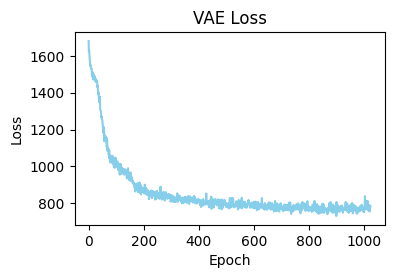

In [161]:
plt.figure(figsize=(4, 2.5))
plt.plot(losses, color='skyblue')
plt.title('VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

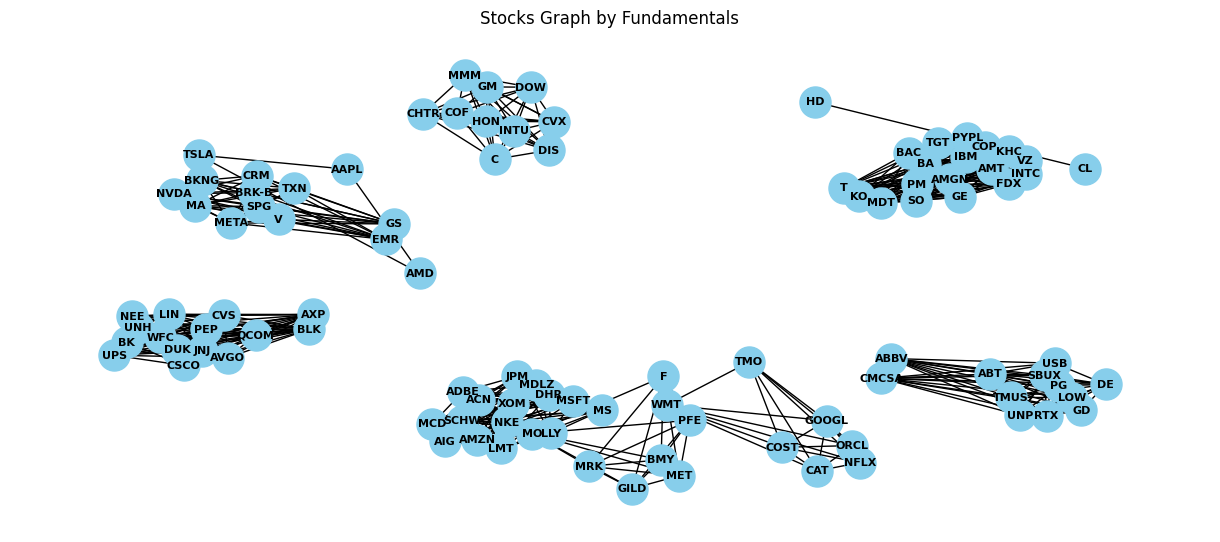

In [168]:
fundamentals_latent = vae.encode(fundamentals_tensor)[0].detach().numpy()

n_clusters = 10
clusters = get_clusters(fundamentals_latent, n_clusters)
adj_fundamentals = np.zeros((len(fundamentals), len(fundamentals)))
for i, cluster1 in enumerate(clusters):
    for j, cluster2 in enumerate(clusters):
        if i != j:
            adj_fundamentals[i, j] = cluster1 == cluster2
        
fundamentals_graph = nx.from_numpy_array(adj_fundamentals)
fundamentals_graph = nx.relabel_nodes(fundamentals_graph, dict(enumerate(fundamentals.index)))

plt.figure(figsize=(12, 5))
nx.draw(fundamentals_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(fundamentals_graph, k=.5))
plt.title('Stocks Graph by Fundamentals')
plt.show()

In [232]:
# same but with correlation
fundamentals_corr = fundamentals.transpose().corr()
fundamentals_corr = fundamentals_corr - (fundamentals_corr == 1)  # Remove self-correlation
fundamentals_corr.head(n=10)

Symbol,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000000,-0.336218,0.017947,-0.114232,-0.014684,-0.408640,0.163737,-0.479728,-0.170895,0.753534,...,-0.090601,0.037269,-0.320732,-0.254220,-0.384054,0.188091,-0.156779,-0.052009,0.345222,0.048717
ABBV,-0.336218,0.000000,0.317932,-0.487705,-0.573208,-0.040060,-0.145165,0.841071,0.399143,-0.436071,...,-0.067329,0.174749,-0.218789,0.447164,0.272814,-0.286269,0.634949,-0.216156,0.120524,0.378584
ABT,0.017947,0.317932,0.000000,0.238517,0.086092,-0.707896,0.128766,0.443588,0.731012,-0.063220,...,0.542618,0.147843,0.087948,0.090823,-0.515798,0.299186,0.241462,-0.706126,0.466987,-0.166093
ACN,-0.114232,-0.487705,0.238517,0.000000,0.420112,-0.043757,0.085696,-0.284868,-0.055257,0.143446,...,0.156393,0.093966,0.134991,0.159919,-0.395451,-0.070592,-0.310477,-0.264311,0.118328,-0.238548
ADBE,-0.014684,-0.573208,0.086092,0.420112,0.000000,-0.173843,0.349278,-0.178998,0.264358,0.180506,...,0.384843,-0.201466,0.593814,-0.608212,-0.399049,0.650539,-0.698435,-0.198438,-0.278519,-0.786449
AIG,-0.408640,-0.040060,-0.707896,-0.043757,-0.173843,0.000000,-0.230383,-0.088017,-0.666914,-0.131695,...,-0.481584,-0.181702,-0.044774,0.029701,0.771079,-0.461247,0.182381,0.780468,-0.239172,0.343580
AMD,0.163737,-0.145165,0.128766,0.085696,0.349278,-0.230383,0.000000,-0.131317,0.041150,0.423884,...,-0.150841,-0.117724,-0.315737,-0.267860,-0.343996,-0.057196,-0.289000,-0.126027,0.234029,-0.326309
AMGN,-0.479728,0.841071,0.443588,-0.284868,-0.178998,-0.088017,-0.131317,0.000000,0.544057,-0.470093,...,0.030235,0.347784,0.007088,0.164567,0.034487,-0.063399,0.489687,-0.407616,0.122583,0.052888
AMT,-0.170895,0.399143,0.731012,-0.055257,0.264358,-0.666914,0.041150,0.544057,0.000000,-0.263825,...,0.689418,-0.084860,0.380449,-0.038956,-0.395134,0.513846,-0.008060,-0.717890,0.040759,-0.368263


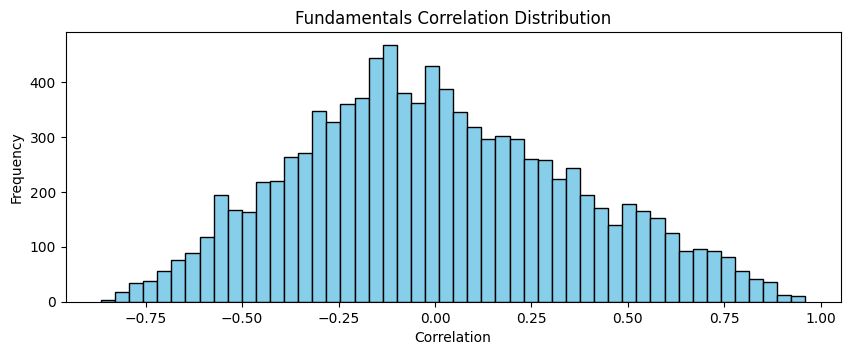

In [233]:
plt.figure(figsize=(10, 3.5))
plt.hist(fundamentals_corr.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Fundamentals Correlation Distribution')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

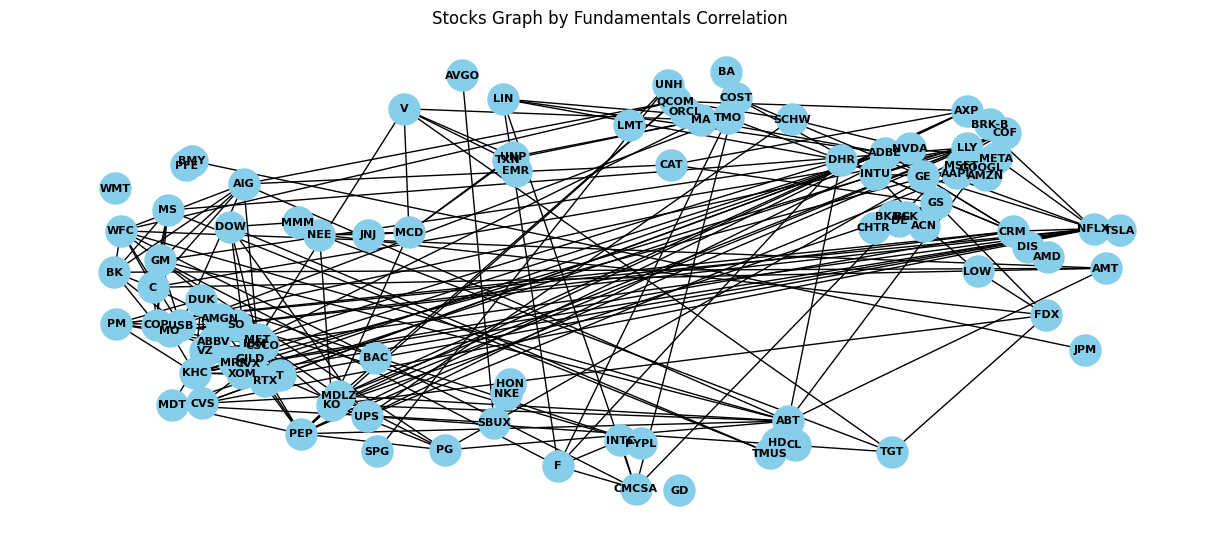

In [234]:
adj_fundamentals_corr = (fundamentals_corr * (abs(fundamentals_corr) > .7).astype(int)).to_numpy()

fundamentals_corr_graph = nx.from_numpy_array(adj_fundamentals_corr)
fundamentals_corr_graph = nx.relabel_nodes(fundamentals_corr_graph, dict(enumerate(fundamentals_corr.index)))

plt.figure(figsize=(12, 5))
nx.draw(fundamentals_corr_graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(fundamentals_corr_graph))
plt.title('Stocks Graph by Fundamentals Correlation')
plt.show()

## Merging the graphs
To make use of the three graphs, the adjacency matrices are summed and normalized, and the resulting graph is plotted. Each adjancency matrix is given a weight for the sum.

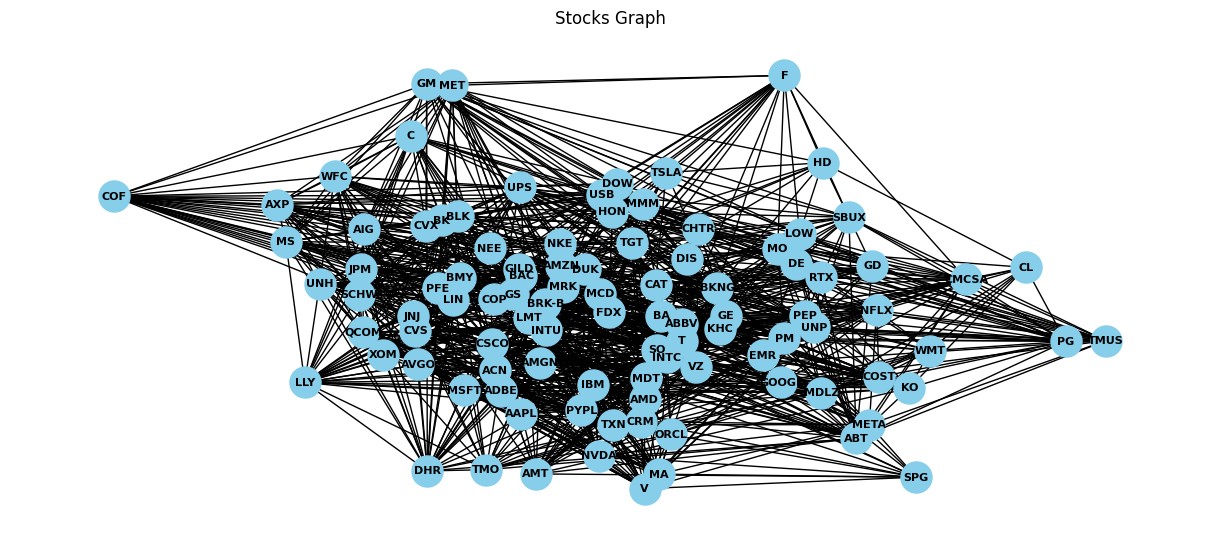

In [235]:
a, b, c = .5, .5, 1

adj = a * adj_stocks + b * adj_fundamentals + c * adj_fundamentals_corr
adj = adj / abs(adj.max())

graph = nx.from_numpy_array(adj)
graph = nx.relabel_nodes(graph, dict(enumerate(stocks.index)))

plt.figure(figsize=(12, 5))
nx.draw(graph, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='bold', font_color='black', pos=nx.spring_layout(graph, k=.5))
plt.title('Stocks Graph')
plt.show()

## Creating the PyTorch Geometric format graph
The adjacency matrix is converted to a PyTorch tensor, and the stock historical values are loaded and converted to a tensor, representing the features of the nodes. 

In [238]:
values = pd.read_csv('../data/SP100/raw/values.csv').set_index(['Symbol', 'Date'])
values.head(n=10)

Close    Volume  Variation       RSI  \
Symbol Date                                                                  
AAPL   2019-06-11 00:00:00-04:00  47.066399  0.195742  -0.000257  0.594733   
       2019-06-12 00:00:00-04:00  46.916603 -0.472418   0.001237  0.583426   
       2019-06-13 00:00:00-04:00  46.906933 -0.209040  -0.002825  0.582656   
       2019-06-14 00:00:00-04:00  46.566288 -0.433289   0.006212  0.554871   
       2019-06-17 00:00:00-04:00  46.844131 -0.748321   0.005132  0.572767   
       2019-06-18 00:00:00-04:00  47.945827  0.166343   0.012242  0.635366   
       2019-06-19 00:00:00-04:00  47.805691 -0.251410  -0.009064  0.622864   
       2019-06-20 00:00:00-04:00  48.189854 -0.221403  -0.004542  0.643569   
       2019-06-21 00:00:00-04:00  48.025555  1.802129  -0.000101  0.627697   
       2019-06-24 00:00:00-04:00  47.977234 -0.474943   0.000202  0.622832   

                                      MACD  BhB  BlB  
Symbol Date                                           
AAPL   2019-06-11 00:00:00-04:00 -0.578354  0.0  0.0  
       2019-06-12 00:00:00-04:00 -0.379584  0.0  0.0  
       2019-06-13 00:00:00-04:00 -0.220298  0.0  0.0  
       2019-06-14 00:00:00-04:00 -0.120164  0.0  0.0  
       2019-06-17 00:00:00-04:00 -0.018179  0.0  0.0  
       2019-06-18 00:00:00-04:00  0.149816  0.0  0.0  
       2019-06-19 00:00:00-04:00  0.268550  0.0  0.0  
       2019-06-20 00:00:00-04:00  0.389160  0.0  0.0  
       2019-06-21 00:00:00-04:00  0.466114  0.0  0.0  
       2019-06-24 00:00:00-04:00  0.517239  0.0  0.0

In [242]:
graph_int_idx = nx.relabel_nodes(graph, {v: k for k, v in dict(enumerate(stocks.index)).items()})  # relabeling nodes to integers

x = torch.tensor(values.to_numpy().reshape(len(stocks.index), -1, values.shape[1]), dtype=torch.float32)
edge_index = torch.tensor([[edge[0] for edge in graph_int_idx.edges], [edge[1] for edge in graph_int_idx.edges]], dtype=torch.long)
edge_weight = torch.tensor([graph_int_idx.edges[edge]['weight'] for edge in graph_int_idx.edges], dtype=torch.float32)
x.shape, edge_index.shape, edge_weight.shape

(torch.Size([100, 1234, 7]), torch.Size([2, 1230]), torch.Size([1230]))

In [244]:
torch.save(x, '../data/SP100/processed/x.pt')
torch.save(edge_index, '../data/SP100/processed/edge_index.pt')
torch.save(edge_weight, '../data/SP100/processed/edge_weight.pt')
torch.save(torch.tensor(adj), '../data/SP100/processed/adj.pt')